**MORPHOLOGY**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from IPython.display import display

In [ ]:
uploaded = files.upload()
filename = next(iter(uploaded))
image_data = uploaded[filename]

Saving test.png to test.png


In [ ]:
def load_image_manually(image_data):
    try:
        img = plt.imread(io.BytesIO(image_data))

        if len(img.shape) > 2:
            img = np.mean(img, axis=2)

        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)

        return img
    except:
        with io.BytesIO(image_data) as f:
            header = f.readline().decode().strip()
            if header == 'P5':
                while True:
                    line = f.readline().decode().strip()
                    if not line.startswith('#'):
                        width, height = map(int, line.split())
                        break
                max_val = int(f.readline().decode().strip())
                img = np.frombuffer(f.read(), dtype=np.uint8).reshape((height, width))
                return img
            else:
                raise ValueError("Unsupported image format")

In [ ]:
img = load_image_manually(image_data)

In [ ]:
def otsu_threshold(image):
    """Calculate Otsu's threshold for image binarization"""
    pixel_counts = [np.sum(image == i) for i in range(256)]

    s_max = (0, -1)

    for threshold in range(256):
        w_b = sum(pixel_counts[:threshold]) / (image.size + 1e-6)
        mu_b = sum(i * pixel_counts[i] for i in range(threshold)) / (sum(pixel_counts[:threshold]) + 1e-6)

        w_f = sum(pixel_counts[threshold:]) / (image.size + 1e-6)
        mu_f = sum(i * pixel_counts[i] for i in range(threshold, 256)) / (sum(pixel_counts[threshold:]) + 1e-6)

        s_b = w_b * w_f * (mu_b - mu_f) ** 2

        if s_b > s_max[1]:
            s_max = (threshold, s_b)

    return s_max[0]

In [ ]:
threshold = otsu_threshold(img)
binary_img = (img > threshold).astype(np.uint8) * 255

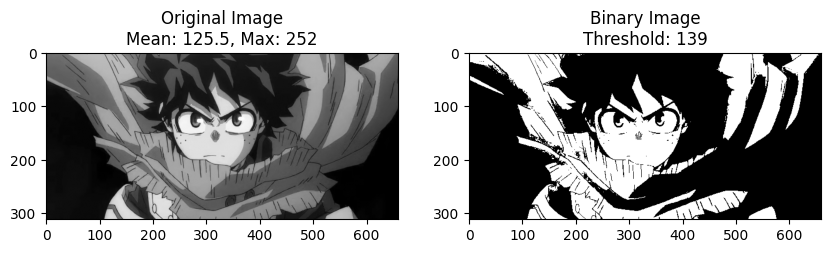

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title(f'Original Image\nMean: {np.mean(img):.1f}, Max: {img.max()}')
plt.subplot(122), plt.imshow(binary_img, cmap='gray'), plt.title(f'Binary Image\nThreshold: {threshold}')
plt.show()

In [ ]:
print("Image statistics:")
print(f"Original shape: {img.shape}, dtype: {img.dtype}")
print(f"Min: {img.min()}, Max: {img.max()}, Mean: {np.mean(img):.1f}")
print(f"Binary unique values: {np.unique(binary_img)}")

Image statistics:
Original shape: (312, 660), dtype: uint8
Min: 63, Max: 252, Mean: 125.5
Binary unique values: [  0 255]


**Binary Morphological Operations**

In [ ]:
def dilate(img, kernel):
    """Dilation operation"""
    h, w = img.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)

    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.max(region * kernel)

    return output

In [ ]:
def erode(img, kernel):
    """Erosion operation"""
    h, w = img.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)

    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.min(region[np.where(kernel == 1)]) if np.all(region[np.where(kernel == 1)] > 0) else 0

    return output

In [ ]:
cross_kernel = np.array([[0, 1, 0],
                         [1, 1, 1],
                         [0, 1, 0]])

square_kernel = np.ones((3, 3), dtype=np.uint8)

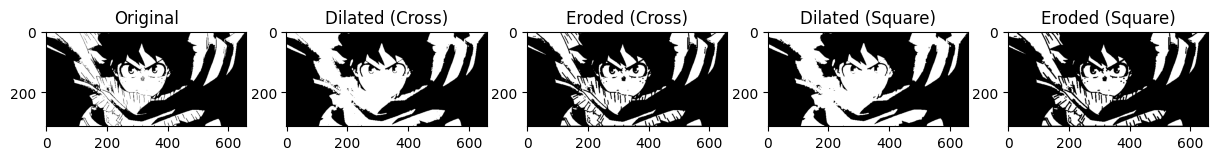

In [ ]:
dilated_cross = dilate(binary_img, cross_kernel)
eroded_cross = erode(binary_img, cross_kernel)
dilated_square = dilate(binary_img, square_kernel)
eroded_square = erode(binary_img, square_kernel)

show_images([binary_img, dilated_cross, eroded_cross, dilated_square, eroded_square],
            ['Original', 'Dilated (Cross)', 'Eroded (Cross)', 'Dilated (Square)', 'Eroded (Square)'])

In [ ]:
def hit_or_miss(img, kernel_hit, kernel_miss):
    """Hit-or-Miss transform"""
    img_bin = (img > 128).astype(np.uint8) * 255

    hit = erode(img_bin, kernel_hit)

    img_complement = 255 - img_bin
    miss = erode(img_complement, kernel_miss)

    result = hit & miss
    return result

In [ ]:
kernel_hit1 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [1, 0, 0]])

kernel_miss1 = np.array([[1, 1, 1],
                         [1, 0, 0],
                         [0, 0, 0]])

kernel_hit2 = np.array([[0, 1, 0],
                        [0, 1, 0],
                        [0, 1, 0]])

kernel_miss2 = np.array([[1, 0, 1],
                         [1, 0, 1],
                         [1, 0, 1]])

kernel_hit3 = np.array([[0, 0, 0],
                        [1, 1, 0],
                        [0, 1, 0]])

kernel_miss3 = np.array([[1, 1, 1],
                         [0, 0, 1],
                         [1, 0, 1]])

In [ ]:
hom_result1 = hit_or_miss(binary_img, kernel_hit1, kernel_miss1)
hom_result2 = hit_or_miss(binary_img, kernel_hit2, kernel_miss2)
hom_result3 = hit_or_miss(binary_img, kernel_hit3, kernel_miss3)

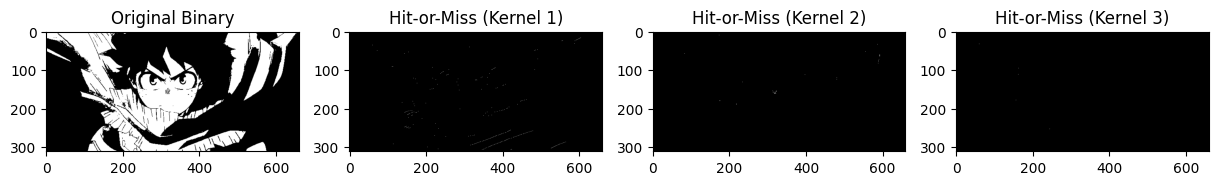

In [ ]:
show_images([binary_img, hom_result1, hom_result2, hom_result3],
            ['Original Binary',
             'Hit-or-Miss (Kernel 1)',
             'Hit-or-Miss (Kernel 2)',
             'Hit-or-Miss (Kernel 3)'])

In [ ]:
def opening(img, kernel):
    """Opening: erosion followed by dilation"""
    return dilate(erode(img, kernel), kernel)

In [ ]:
def closing(img, kernel):
    """Closing: dilation followed by erosion"""
    return erode(dilate(img, kernel), kernel)

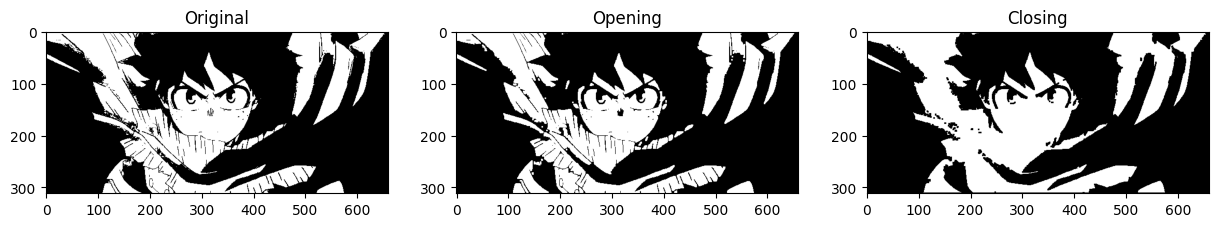

In [ ]:
opened_img = opening(binary_img, square_kernel)
closed_img = closing(binary_img, square_kernel)

show_images([binary_img, opened_img, closed_img],
            ['Original', 'Opening', 'Closing'])

**Gray Scale Morphological Operations**

In [ ]:
def grayscale_dilate(img, kernel):
    """Grayscale dilation"""
    h, w = img.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)

    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.max(region + kernel - 1)

    return output

In [ ]:
def grayscale_erode(img, kernel):
    """Grayscale erosion"""
    h, w = img.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)

    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.min(region - kernel + 1)

    return output


In [ ]:
gray_dilated = grayscale_dilate(img, square_kernel)
gray_eroded = grayscale_erode(img, square_kernel)
gray_opened = grayscale_dilate(grayscale_erode(img, square_kernel), square_kernel)
gray_closed = grayscale_erode(grayscale_dilate(img, square_kernel), square_kernel)

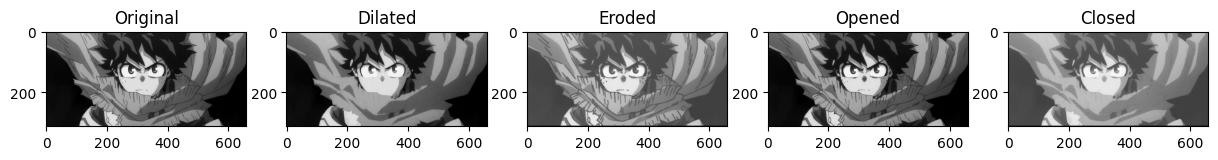

In [ ]:
show_images([img, gray_dilated, gray_eroded, gray_opened, gray_closed],
            ['Original', 'Dilated', 'Eroded', 'Opened', 'Closed'])

**Some Basic Morphological Operations**

In [ ]:
def boundary_extraction(img, kernel):
    """Boundary extraction: original minus erosion"""
    return img - erode(img, kernel)

boundary = boundary_extraction(binary_img, square_kernel)

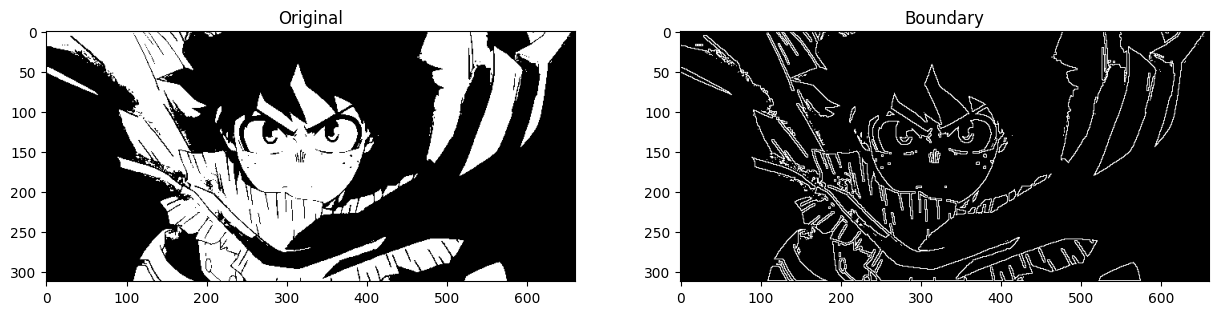

In [ ]:
show_images([binary_img, boundary], ['Original', 'Boundary'])

In [ ]:
def region_filling(img, seed_point, kernel):
    """Region filling using morphological operations"""
    h, w = img.shape
    X = np.zeros_like(img)
    X[seed_point] = 255

    while True:
        X_prev = X.copy()
        X = dilate(X, kernel) & (255 - img)
        if np.array_equal(X, X_prev):
            break

    return img | X

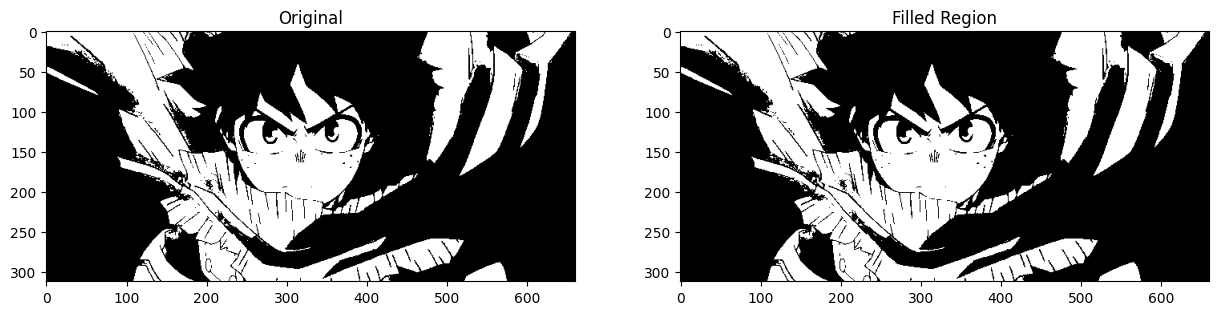

In [ ]:
background_points = np.argwhere(binary_img == 0)
if len(background_points) > 0:
    seed = tuple(background_points[0])
    filled = region_filling(binary_img, seed, cross_kernel)
    show_images([binary_img, filled], ['Original', 'Filled Region'])
else:
    print("No background pixels found for region filling.")

In [ ]:
def quickhull_convex_hull(binary_img):
    """Convex Hull implementation using QuickHull algorithm"""
    boundary = binary_img - erode(binary_img, np.ones((3,3)))
    points = np.argwhere(boundary > 0)

    if len(points) < 3:
        return binary_img

    points = [tuple(p) for p in points]

    left = min(points, key=lambda p: p[1])
    right = max(points, key=lambda p: p[1])

    hull = set([left, right])

    def find_hull(points, p1, p2, side):
        if not points:
            return []

        max_dist = -1
        farthest_point = None
        line_vec = (p2[0]-p1[0], p2[1]-p1[1])

        for p in points:
            vec = (p[0]-p1[0], p[1]-p1[1])
            cross = line_vec[0]*vec[1] - line_vec[1]*vec[0]
            dist = abs(cross)

            if dist > max_dist:
                max_dist = dist
                farthest_point = p

        if farthest_point is None:
            return []

        hull.add(farthest_point)

        points.remove(farthest_point)
        new_points = []

        for p in points:
            if point_location(p1, farthest_point, p) == side:
                new_points.append(p)

        find_hull(new_points, p1, farthest_point, -point_location(p1, farthest_point, p))

        new_points = []
        for p in points:
            if point_location(farthest_point, p2, p) == side:
                new_points.append(p)

        find_hull(new_points, farthest_point, p2, -point_location(farthest_point, p2, p))

    def point_location(a, b, p):
        val = (b[0]-a[0])*(p[1]-a[1]) - (b[1]-a[1])*(p[0]-a[0])
        return 1 if val > 0 else (-1 if val < 0 else 0)

    left_points = []
    right_points = []
    line_vec = (right[0]-left[0], right[1]-left[1])

    for p in points:
        if p == left or p == right:
            continue
        vec = (p[0]-left[0], p[1]-left[1])
        cross = line_vec[0]*vec[1] - line_vec[1]*vec[0]
        if cross > 0:
            left_points.append(p)
        elif cross < 0:
            right_points.append(p)

    find_hull(left_points, left, right, 1)
    find_hull(right_points, left, right, -1)

    hull = list(hull)

    center = (sum(p[0] for p in hull)/len(hull), sum(p[1] for p in hull)/len(hull))
    hull.sort(key=lambda p: np.arctan2(p[0]-center[0], p[1]-center[1]))

    output = np.zeros_like(binary_img)

    for i in range(len(hull)):
        p1 = hull[i]
        p2 = hull[(i+1)%len(hull)]
        draw_line(output, p1, p2)

    filled = region_filling(output, (hull[0][0], hull[0][1]), np.ones((3,3)))
    return filled

In [ ]:
def draw_line(img, p1, p2):
    """Bresenham's line drawing algorithm"""
    x1, y1 = p1
    x2, y2 = p2
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        img[x1, y1] = 255
        if x1 == x2 and y1 == y2:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

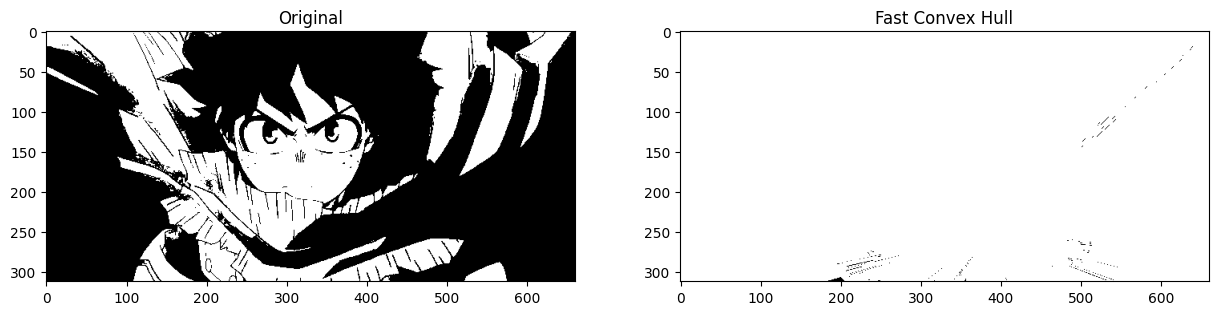

In [ ]:
hull_fast = quickhull_convex_hull(binary_img)
show_images([binary_img, hull_fast], ['Original', 'Fast Convex Hull'])

**Skeletonization**

In [ ]:
def safe_erode(img, kernel):
    """Erosion dengan penanganan kasus khusus"""
    try:
        kernel = (kernel > 0).astype(np.uint8)

        if np.all(kernel == 0):
            return img.copy()

        h, w = img.shape
        kh, kw = kernel.shape
        pad_h, pad_w = kh // 2, kw // 2

        padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
        output = np.zeros_like(img)

        for i in range(h):
            for j in range(w):
                region = padded[i:i+kh, j:j+kw]
                if np.any(kernel == 1):
                    min_val = np.min(region[np.where(kernel == 1)])
                    output[i, j] = min_val if np.all(region[np.where(kernel == 1)] > 0) else 0

        return output
    except Exception as e:
        print(f"Error dalam erosi: {e}")
        return np.zeros_like(img)

In [ ]:
def robust_skeletonize(img, max_iter=100):
    """Implementasi skeletonization yang lebih robust"""
    if len(img.shape) > 2:
        img = img[:,:,0]
    img_bin = (img > 128).astype(np.uint8) * 255

    kernels = [
        np.array([[0,0,0], [1,1,1], [0,0,0]], dtype=np.uint8),  # Horizontal
        np.array([[0,0,0], [0,1,0], [0,1,0]], dtype=np.uint8),  # Vertikal 1
        np.array([[0,0,0], [1,1,0], [0,1,0]], dtype=np.uint8),  # Diagonal 1
        np.array([[0,1,0], [0,1,0], [0,1,0]], dtype=np.uint8),  # Vertikal 2
        np.array([[0,1,0], [1,1,0], [0,0,0]], dtype=np.uint8),  # Diagonal 2
        np.array([[0,0,0], [0,1,1], [0,1,0]], dtype=np.uint8),  # Diagonal 3
        np.array([[0,0,0], [0,1,0], [1,1,0]], dtype=np.uint8),  # Diagonal 4
        np.array([[0,0,1], [0,1,1], [0,0,1]], dtype=np.uint8)   # Kombinasi
    ]

    skeleton = img_bin.copy()
    prev_skeleton = np.zeros_like(skeleton)

    for _ in range(max_iter):
        prev_skeleton = skeleton.copy()

        for kernel in kernels:
            hit = safe_erode(skeleton, kernel)
            miss = safe_erode(255 - skeleton, 255 - kernel)

            if np.any(hit) and np.any(miss):
                hom = hit & miss
                skeleton = skeleton & ~hom

        if np.array_equal(skeleton, prev_skeleton):
            break

    return skeleton

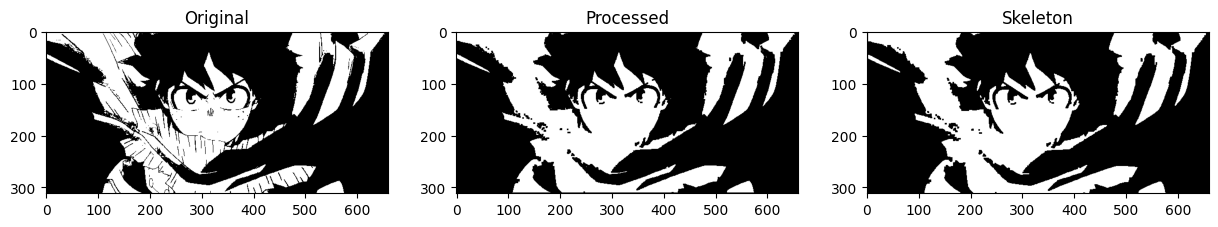

In [ ]:
try:
    processed_img = binary_img.copy()

    processed_img = closing(processed_img, np.ones((3,3), dtype=np.uint8))

    skeleton = robust_skeletonize(processed_img)

    skeleton = opening(skeleton, np.ones((2,2), dtype=np.uint8))

    show_images([binary_img, processed_img, skeleton],
                ['Original', 'Processed', 'Skeleton'])

except Exception as e:
    print(f"Error utama: {e}")
    print("Mencoba fallback method...")

    skeleton = binary_img.copy()
    for _ in range(10):
        markers = np.zeros_like(skeleton)
        for k in [np.array([[0,1,0],[1,1,1],[0,1,0]])]:
            markers |= (safe_erode(skeleton, k) & safe_erode(255-skeleton, 255-k))
        if not np.any(markers):
            break
        skeleton = skeleton & ~markers

    show_images([binary_img, skeleton], ['Original', 'Simple Skeleton'])

**Granularity**

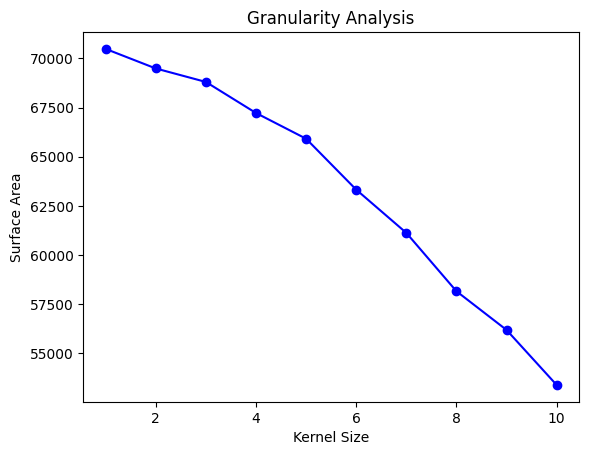

In [ ]:
def granularity_analysis(img, max_size=10):
    """Granularity analysis using opening operations"""
    sizes = range(1, max_size + 1)
    square_kernels = [np.ones((s, s), dtype=np.uint8) for s in sizes]

    surface_areas = []
    for kernel in square_kernels:
        opened = opening(img, kernel)
        surface_areas.append(np.sum(opened) / 255)

    plt.plot(sizes, surface_areas, 'bo-')
    plt.xlabel('Kernel Size')
    plt.ylabel('Surface Area')
    plt.title('Granularity Analysis')
    plt.show()

    return surface_areas

granularity = granularity_analysis(binary_img)

**Morphological Segmentation and Watersheds**

In [ ]:
def distance_transform(img):
    """Simple distance transform"""
    dt = np.zeros_like(img, dtype=np.float32)
    h, w = img.shape

    for i in range(h):
        for j in range(w):
            if img[i, j] == 255:
                min_dist = float('inf')
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < h and 0 <= nj < w:
                            if di == 0 and dj == 0:
                                continue
                            min_dist = min(min_dist, dt[ni, nj] + np.sqrt(di**2 + dj**2))
                dt[i, j] = min_dist if min_dist != float('inf') else 0

    for i in range(h-1, -1, -1):
        for j in range(w-1, -1, -1):
            if img[i, j] == 255:
                min_dist = float('inf')
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < h and 0 <= nj < w:
                            if di == 0 and dj == 0:
                                continue
                            min_dist = min(min_dist, dt[ni, nj] + np.sqrt(di**2 + dj**2))
                dt[i, j] = min(dt[i, j], min_dist) if min_dist != float('inf') else dt[i, j]

    return dt

In [ ]:
def watershed_segmentation(img):
    """Simplified watershed segmentation"""
    dt = distance_transform(img)

    markers = np.zeros_like(img)
    h, w = img.shape

    for i in range(1, h-1):
        for j in range(1, w-1):
            if dt[i, j] > dt[i-1, j] and dt[i, j] > dt[i+1, j] and \
               dt[i, j] > dt[i, j-1] and dt[i, j] > dt[i, j+1]:
                markers[i, j] = 255

    labeled = connected_components(markers, cross_kernel)

    watershed = np.zeros_like(img)
    max_dt = np.max(dt)

    for level in range(int(max_dt), 0, -1):
        mask = (dt >= level).astype(np.uint8) * 255
        dilated = dilate(labeled, cross_kernel)
        watershed = np.where(mask == 255, dilated, watershed)

    return watershed

In [ ]:
watershed_result = watershed_segmentation(binary_img)

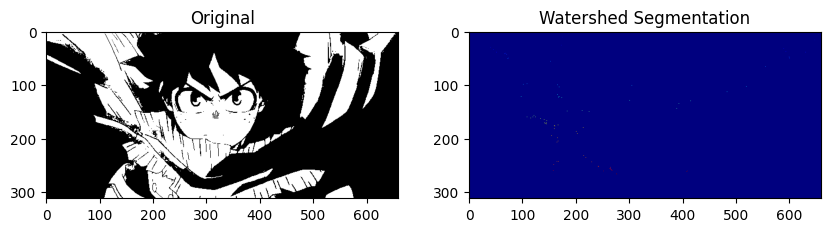

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(binary_img, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(watershed_result, cmap='jet'), plt.title('Watershed Segmentation')
plt.show()